# Backpropagation from scratch

Original Source is: [The spelled-out intro to neural networks and backpropagation: building micrograd](https://youtu.be/VMj-3S1tku0?si=ooLtYbzFeESjd3Li) by Andrej Karpathy.

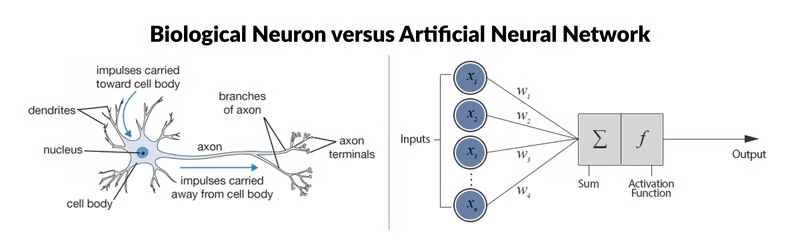

## Set up environment

In [1]:
import random
random.seed(42)

import numpy as np
np.random.seed(42) 

import pandas as pd
from pandas import DataFrame

from typing import List, Callable

from matplotlib import pyplot as plt

from graphviz import Digraph

import functools

import copy

## Hyperparams

In [ ]:
TEST_SIZE = 0.1

# 1e-2 is too high for more than one neuron (exploding gradients)
# 1e-3 makes training too erratic (jumping around minimum)
LEARNING_RATE = 1e-4
BATCH_SIZE = 8
EPOCHS = 500

HIDDEN_LAYERS_NUM = 1
HIDDEN_NEURONS_NUM = 8


## Utilities

In [3]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

## Load data

In [4]:
df = pd.read_csv("ice_cream_data.csv", sep=",")
df = df.sample(frac=1, random_state=42)
df.head()

,Temperature,Is_Weekend,Ice_Creams_Sold
110,18.692544,1,203
419,32.571236,0,275
565,27.697531,1,274
77,12.221340,0,104
181,13.404206,0,136


### Separate input from target

In [5]:
targets = df["Ice_Creams_Sold"]
inputs = df.drop(["Ice_Creams_Sold"], axis=1)

In [6]:
inputs.min()

Temperature    10.151848
Is_Weekend      0.000000
dtype: float64

In [7]:
inputs.max()

Temperature    39.99153
Is_Weekend      1.00000
dtype: float64

### Normalize input

In [8]:
def normalize_input(X: DataFrame):
    result = (X - X.min()) / (X.max() - X.min())
    return result

In [9]:
norm_inputs = normalize_input(inputs)

In [10]:
norm_inputs.min()

Temperature    0.0
Is_Weekend     0.0
dtype: float64

In [11]:
norm_inputs.max()

Temperature    1.0
Is_Weekend     1.0
dtype: float64

### Numpy

In [12]:
inputs = norm_inputs.to_numpy()
inputs[:5]

array([[0.2862194 , 1.        ],
       [0.75132798, 0.        ],
       [0.58799831, 1.        ],
       [0.06935369, 0.        ],
       [0.10899439, 0.        ]])

In [13]:
inputs.shape

(600, 2)

In [14]:
targets = targets.to_numpy()
targets[:5]

array([203, 275, 274, 104, 136])

### Train vs. Test set

In [15]:
test_size = int(len(inputs) * TEST_SIZE)
print(f"Train size: {len(inputs) - test_size}, Test size: {test_size}")

inputs_train = inputs[:-test_size]
targets_train = targets[:-test_size]

inputs_test = inputs[-test_size:]
targets_test = targets[-test_size:]

Train size: 540, Test size: 60


## Train Model

### Model

In [16]:
class Variable:
    def __init__(self, label = "", data = 0.0, _children = (), _op = "", trainable = False):
        self.label = label
        self._forward = None
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._trainable = trainable

        # It is important to use list because order of children is important for weight updates
        self._prev = list(_children)
        self._op = _op

    def __str__(self):
        return f"{self.label}:{self.data}"

    def __add__(self, other):
        result = Variable(_children=(self, other), _op="+")

        def forward():
            return self.forward() + other.forward()
        result._forward = forward

        def backward():
            self.grad = 1.0 * result.grad
            other.grad = 1.0 * result.grad
        result._backward = backward
        
        return result

    def __mul__(self, other):
        result = Variable(_children=(self, other), _op="*")

        def forward():
            return self.forward() * other.forward()
        result._forward = forward
        
        def backward():
            self.grad = other.data * result.grad
            other.grad = self.data * result.grad
        result._backward = backward

        return result
    
    def tanh(self):
        result = Variable(_children=(self,), _op="tanh")

        def forward():
            return np.tanh(self.forward())
        result._forward = forward
        
        def backward():
            self.grad = (1 - np.tanh(self.data) ** 2) * result.grad
        result._backward = backward

        return result
    
    def mse(self, target):
        result = Variable(_children=(self, target), _op="mse")

        def forward():
            return (target.forward() - self.forward()) ** 2
        result._forward = forward

        def backward():
            self.grad = 2 * (self.data - target.data)
            target.grad = 2 * (target.data - self.data)
        result._backward = backward

        return result

    def forward(self):
        if self._forward:
            self.data = self._forward()
        return self.data

    def backward(self):
        # Base case
        self.grad = 1.0
        self._backward()

        nodes = list(self._prev)
        while nodes:
            node = nodes.pop()
            nodes.extend(list(node._prev))
            node._backward()
            if (node._trainable):
                node.data = node.data - node.grad * LEARNING_RATE

    def update_weights(self, source):
        nodes_current = list(self._prev)
        nodes_source = list(source._prev)
        while nodes_current and nodes_source:
            node_current = nodes_current.pop()
            node_source = nodes_source.pop()

            nodes_current.extend(list(node_current._prev))
            nodes_source.extend(list(node_source._prev))

            if (node_current._trainable):
                node_current.data = node_source.data

In [17]:
def neuron(inputs: List, use_activation = False):
    bias = Variable(label="bias", data=0.01, trainable=True)

    # Xavier/Glorot initialization (simplified since output is 1)
    scale = 1.0 / np.sqrt(len(inputs))
    weighted_inputs = []
    for index, input in enumerate(inputs):
        weight = Variable(label=f"weight{index}", data=np.random.uniform(-scale, scale), trainable=True)
        weighted_input = input * weight
        weighted_input.label = f"weighted_input{index}"
        weighted_inputs.append(weighted_input)

    weighted_input_sum = functools.reduce(lambda x, y: x + y, weighted_inputs)
    weighted_input_sum.label = "weighted_input_sum"

    biased_sum = weighted_input_sum + bias
    biased_sum.label = "sum"

    if (use_activation):
        output = biased_sum.tanh()
    else:
        output = biased_sum
    output.label = "output"

    return output

In [18]:
input1 = Variable("input1")
input2 = Variable("input2")
target = Variable("target")

inputs = [input1, input2]
hidden_neurons = []
for neuron_index in range(HIDDEN_NEURONS_NUM):
    hidden_neuron_output = neuron(inputs, use_activation=True)
    hidden_neurons.append(hidden_neuron_output)

output_neuron_output = neuron(hidden_neurons)

loss = output_neuron_output.mse(target)
loss.label = "loss"

### Training

In [19]:
data_size_train = len(inputs_train)
data_size_test = len(inputs_test)

min_loss_test = np.inf
best_loss = None
best_epoch = 0
history = {"train_loss": [], "test_loss": []}
indices = np.arange(data_size_train)
for epoch in range(EPOCHS):
    losses_train = []
    losses_test = []

    # Validation
    for input_index in range(data_size_test):
        input1.data = inputs_test[input_index][0]
        input2.data = inputs_test[input_index][1]
        target.data = targets_test[input_index]

        loss_value_test = loss.forward()
        losses_test.append(loss_value_test)

    # Test history for learning curve
    average_loss_test = sum(losses_test) / len(losses_test)
    history["test_loss"].append(average_loss_test)

    # Model Checkpoint
    if (average_loss_test < min_loss_test):
        min_loss_test = average_loss_test
        best_loss = copy.deepcopy(loss)
        best_epoch = epoch

    # Training
    # TODO: there is a bug with having training after model checkpoint
    # - when we reach max number of epochs without triggering Early Stopping - last model (even if best) is not used
    # - we stop training based on previous backprop test evaluation (so we do last backprop unnecessarily)
    np.random.shuffle(indices)
    for batch_index in range(data_size_train // BATCH_SIZE):
        losses = []
        for input_index in range(BATCH_SIZE):
            index = indices[batch_index * BATCH_SIZE + input_index]  # Use shuffled index
            input1.data = inputs_train[index][0]
            input2.data = inputs_train[index][1]
            target.data = targets_train[index]

            loss_value = loss.forward()
            losses.append(loss_value)

        loss_value_train = sum(losses) / len(losses)
        losses_train.append(loss_value_train)

        loss.data = loss_value_train
        loss.backward()

    # Train history for learning curve
    average_loss_train = sum(losses_train) / len(losses_train)
    history["train_loss"].append(average_loss_train)

    print(f"Epoch {epoch}: loss={average_loss_train}, test_loss={average_loss_test}")

    # Early Stopping
    patience = 10
    delta = 1e-3

    train_losses = history["test_loss"]
    if len(train_losses) >= patience + 1 and min(history["test_loss"][:-patience]) - min(history["test_loss"][-patience:]) < delta:
        break

loss.update_weights(best_loss)

Epoch 0: loss=51050.462529794575, test_loss=58437.650731590446
Epoch 1: loss=48521.36453133621, test_loss=56504.00103246676
Epoch 2: loss=44210.27423889742, test_loss=52589.335401356155
Epoch 3: loss=39926.26670900331, test_loss=47678.0151434758
Epoch 4: loss=36097.60825173391, test_loss=43162.94969206086
Epoch 5: loss=32937.106433162546, test_loss=39455.25741041965
Epoch 6: loss=29620.90346360298, test_loss=35991.36193253329
Epoch 7: loss=27030.112194130397, test_loss=32852.32069090651
Epoch 8: loss=24706.51932071942, test_loss=30021.301709230167
Epoch 9: loss=22647.75440348342, test_loss=27605.976302142706
Epoch 10: loss=20689.963990414868, test_loss=25528.23864706892
Epoch 11: loss=18936.01638998908, test_loss=23441.596883229635
Epoch 12: loss=17431.106502815783, test_loss=21551.531536435625
Epoch 13: loss=16141.083677240835, test_loss=19842.218174599522
Epoch 14: loss=14655.438177204782, test_loss=18540.43520771292
Epoch 15: loss=13825.665536525188, test_loss=17181.887054877738
Epo

In [20]:
best_epoch

187

In [21]:
min_loss_test

276.78818950783705

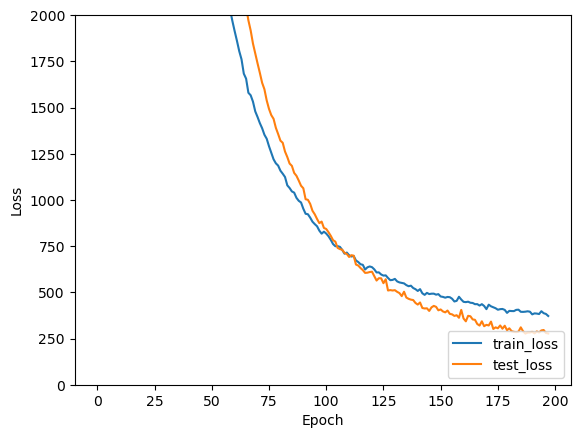

In [22]:
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 2000)
plt.legend(loc="lower right")

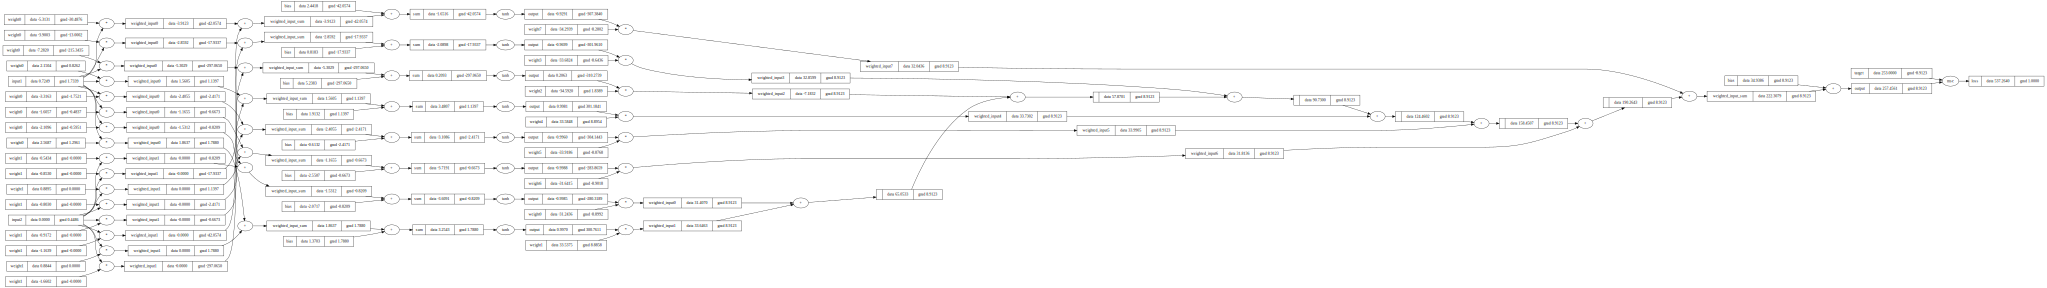

In [23]:
draw_dot(loss)

## Test solution

In [24]:
losses = []
for index in range(len(inputs_test)):
    input1.data = inputs_test[index][0]
    input2.data = inputs_test[index][1]
    target.data = targets_test[index]
    loss_value = loss.forward()
    losses.append(loss_value)

In [25]:
average_loss = sum(losses) // len(losses)
average_loss

276.0

In [26]:
rmse = np.sqrt(np.mean(losses))
mean_target = np.mean(targets)
print("RMSE:", rmse)
print("Mean of targets:", mean_target)

RMSE: 16.636952530672108
Mean of targets: 216.425
